In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
from datetime import datetime
import sys
sys.path.append('../../../spicy-snow/')

from spicy_snow.processing.snow_index import calc_delta_cross_ratio, calc_delta_gamma, \
    clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth
from spicy_snow.processing.wet_snow import id_newly_wet_snow, id_wet_negative_si, \
    id_newly_frozen_snow, flag_wet_snow
from spicy_snow.retrieval import retrieval_from_parameters

from dask.distributed import Client


In [90]:
directory = 'rmse_test_wet_snow'


which_site = 1

results1 = sorted(glob(f'{directory}/*wet*.nc'))
results2 = sorted(glob(f'{directory}/*no*.nc'))
results3 = sorted(glob(f'{directory}/*valid*.nc'))

wet_snow = xr.open_dataarray(results1[which_site])
all_snow = xr.open_dataarray(results2[which_site])
frac_valid = xr.open_dataarray(results3[which_site])

wet_snow = wet_snow.sel(freeze_snow_thresh=slice(1,2))
all_snow = all_snow.sel(freeze_snow_thresh=slice(1,2))
frac_valid = frac_valid.sel(freeze_snow_thresh=slice(1,2))

all_rmse = xr.concat([wet_snow,all_snow],'wet_or_all')



In [106]:
#wet_snow.sel(SI_thresh=0).plot.contour(levels=10,linestyle='--',color='black')

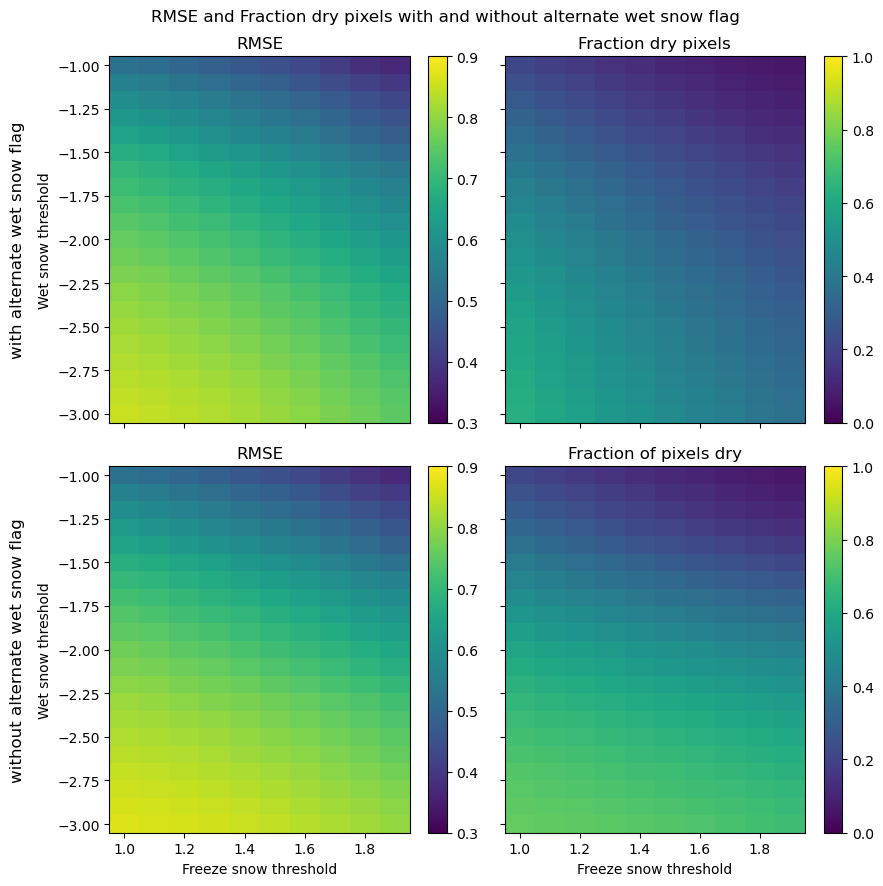

In [119]:
f,ax=plt.subplots(2,2,figsize=(9,9),sharex=True,sharey=True)
wet_snow.sel(SI_thresh=0).plot(ax=ax[0,0],vmin=0.3,vmax=0.9)
frac_valid.sel(SI_thresh=0).plot(ax=ax[0,1],vmin=0,vmax=1)


wet_snow.sel(SI_thresh=-100).plot(ax=ax[1,0],vmin=0.3,vmax=0.9)
frac_valid.sel(SI_thresh=-100).plot(ax=ax[1,1],vmin=0,vmax=1)
ax[1,0].set_title('RMSE')
ax[1,1].set_title('Fraction of pixels dry')

ax[0,0].set_title('RMSE')
ax[0,1].set_title('Fraction dry pixels')

ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')

ax[1,1].set_ylabel('')

ax[0,0].set_ylabel('Wet snow threshold')
ax[1,0].set_ylabel('Wet snow threshold')

ax[1,0].set_xlabel('Freeze snow threshold')
ax[1,1].set_xlabel('Freeze snow threshold')


f.suptitle('RMSE and Fraction dry pixels with and without alternate wet snow flag')

rows=['with alternate wet snow flag','without alternate wet snow flag']
pad = 5
for ax, row in zip(ax[:,0], rows):
    ax.annotate(row,xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-pad,0),                    
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center',rotation=90)
plt.tight_layout()

f.savefig('figures/RMSE_fracdry_mesh.png',dpi=600)

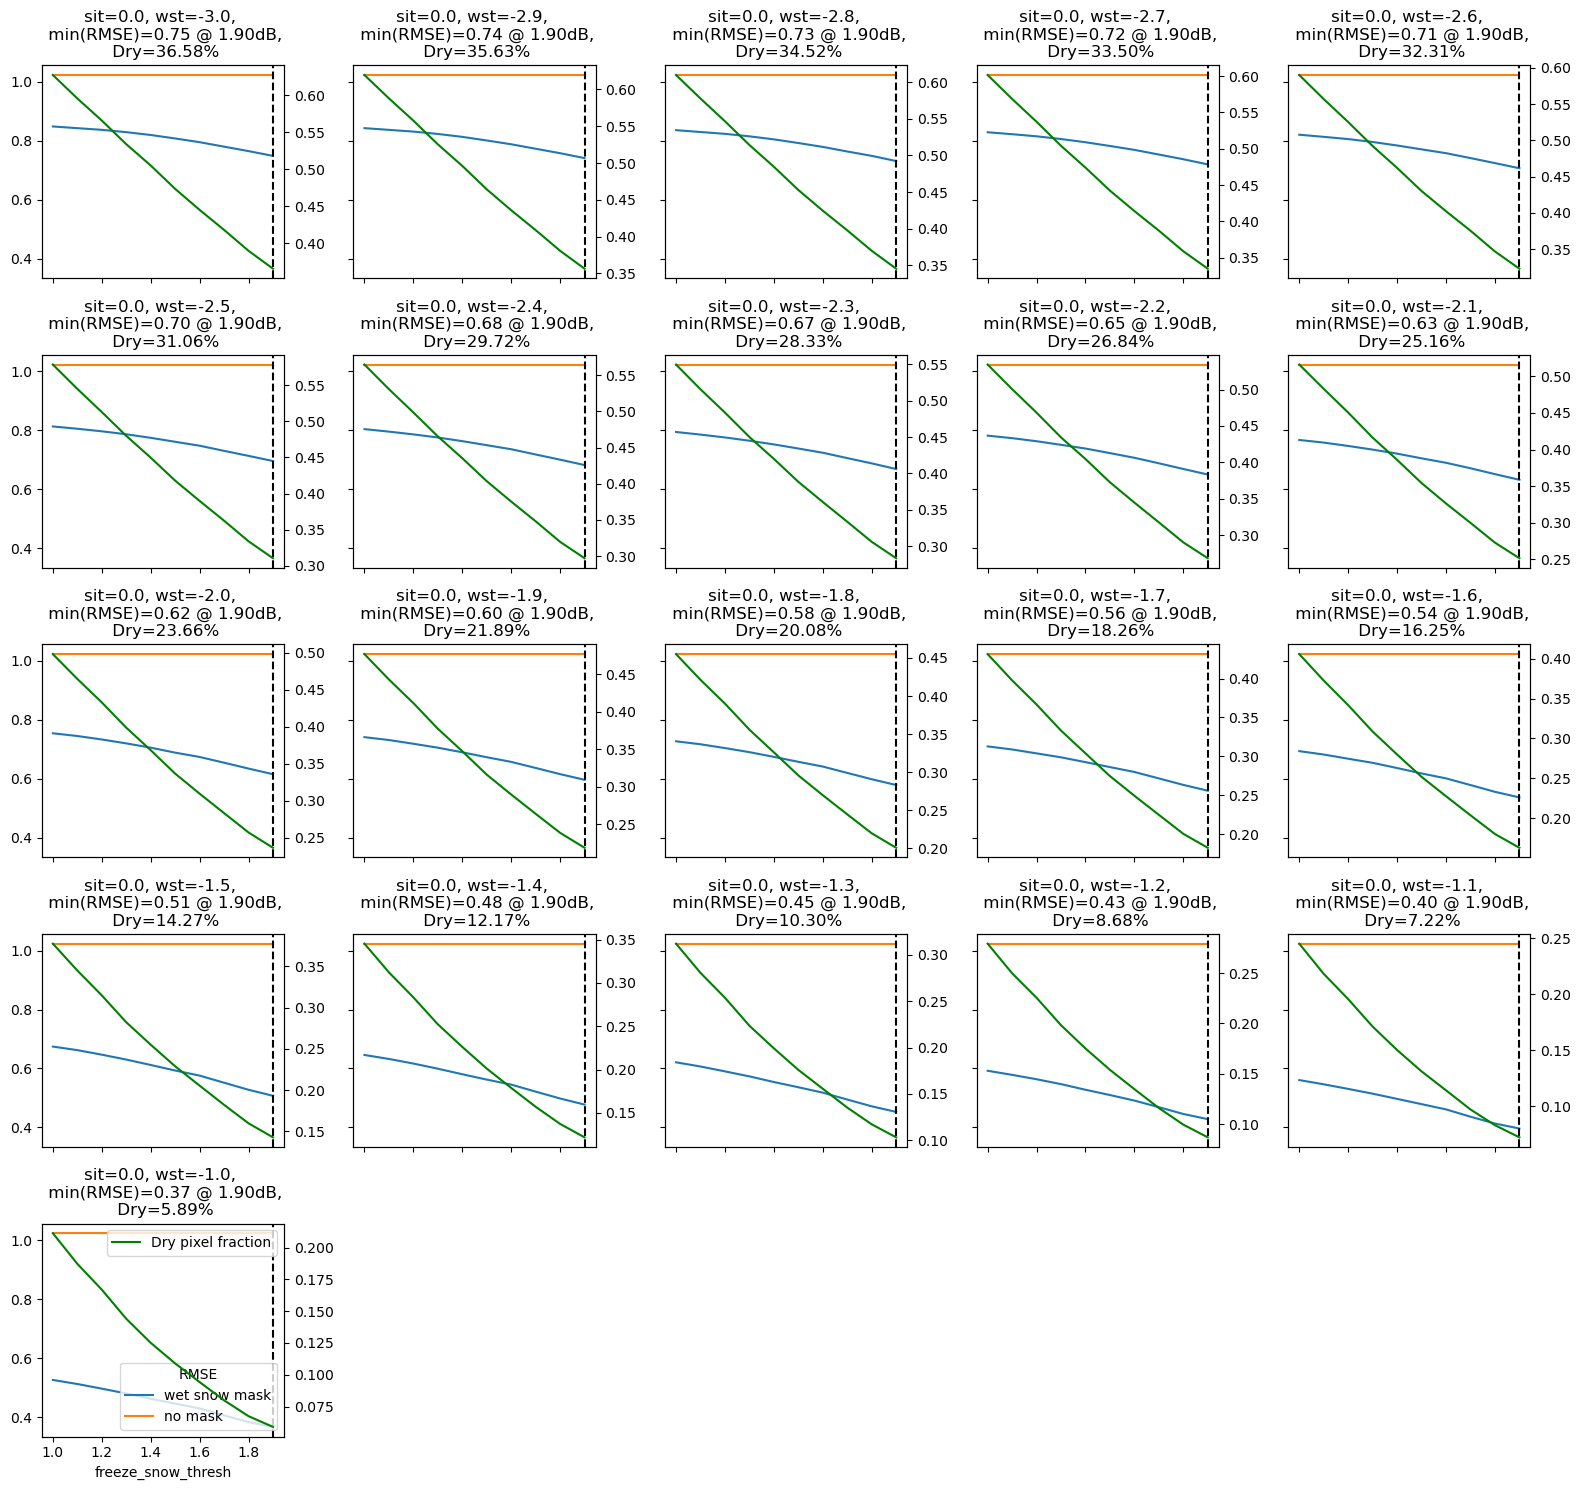

In [95]:
sit = 0
f=all_rmse.sel(SI_thresh=sit).plot(hue='wet_or_all',col='wet_snow_thresh',add_legend=False,col_wrap=5)

for wst,ax in zip(all_rmse.wet_snow_thresh,f.axs.ravel()):
    frac_ax = ax.twinx()
    fv = frac_valid.sel(SI_thresh=sit,wet_snow_thresh=wst).plot(ax=frac_ax,color='green',label='dry pixel fraction')
    frac_ax.set_title('')
    ax.axvline(wet_snow.sel(SI_thresh=sit,wet_snow_thresh=wst).idxmin(),color='black',linestyle='--')
    ax.set_title('')
    dry_percent = 100*frac_valid.sel(SI_thresh=sit,wet_snow_thresh=wst,freeze_snow_thresh=float(wet_snow.sel(SI_thresh=sit,wet_snow_thresh=wst).idxmin()))
    ax.set_title(f'sit={sit:0.1f}, wst={wst:0.1f}, \n min(RMSE)={float(wet_snow.sel(SI_thresh=sit,wet_snow_thresh=wst).min()):0.2f} @ {float(wet_snow.sel(SI_thresh=sit,wet_snow_thresh=wst).idxmin()):0.2f}dB,\n Dry={dry_percent:0.2f}%')

    
ax.legend(labels=['wet snow mask','no mask'], title= 'RMSE', loc='lower right')
frac_ax.legend(handles=fv,labels=['Dry pixel fraction'], loc='upper right')
plt.tight_layout()

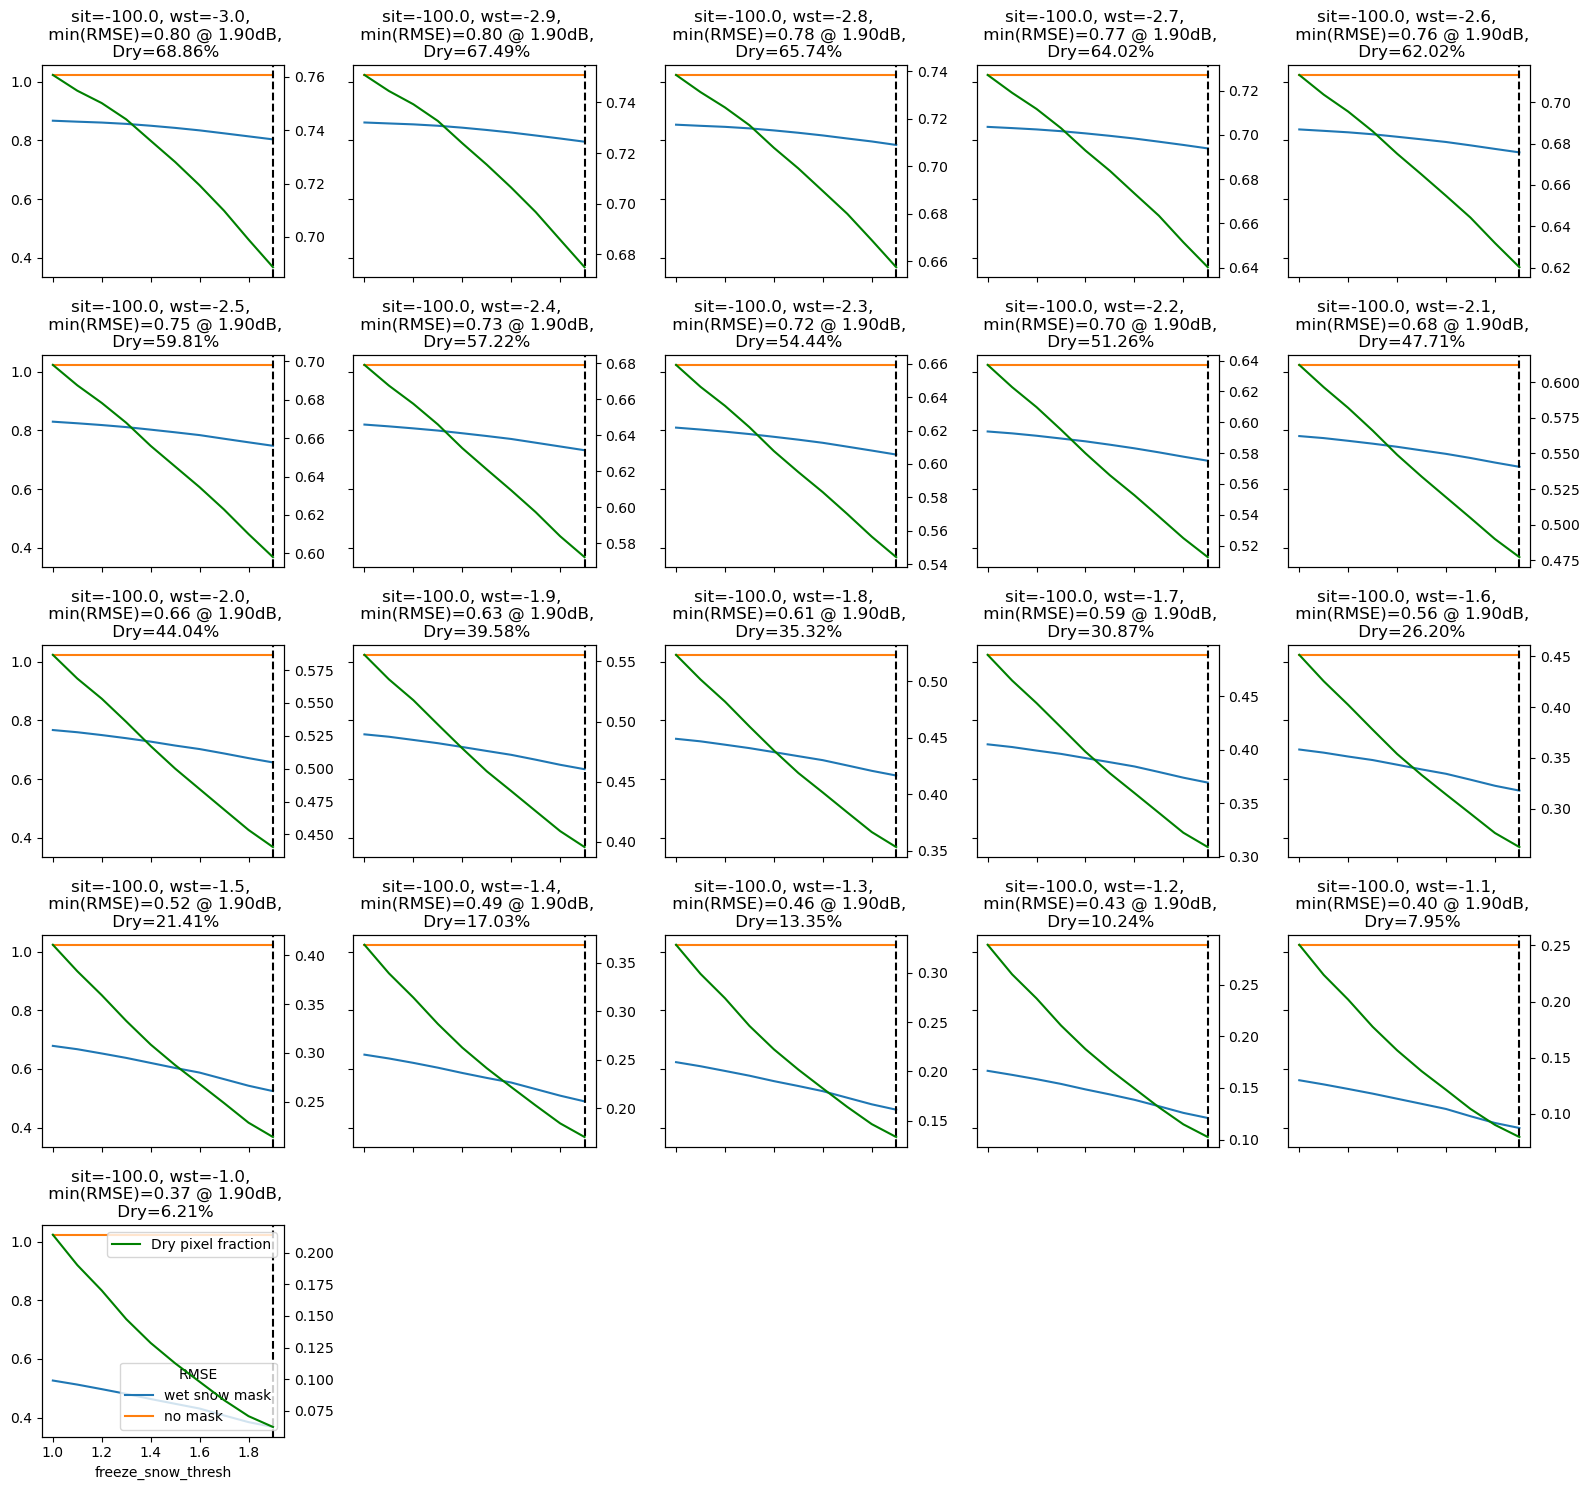

In [96]:
sit = -100
f=all_rmse.sel(SI_thresh=sit).plot(hue='wet_or_all',col='wet_snow_thresh',add_legend=False,col_wrap=5)
for wst,ax in zip(all_rmse.wet_snow_thresh,f.axs.ravel()):
    frac_ax = ax.twinx()
    fv = frac_valid.sel(SI_thresh=sit,wet_snow_thresh=wst).plot(ax=frac_ax,color='green',label='dry pixel fraction')
    frac_ax.set_title('')
    ax.axvline(wet_snow.sel(SI_thresh=sit,wet_snow_thresh=wst).idxmin(),color='black',linestyle='--')
    ax.set_title('')
    dry_percent = 100*frac_valid.sel(SI_thresh=sit,wet_snow_thresh=wst,freeze_snow_thresh=float(wet_snow.sel(SI_thresh=sit,wet_snow_thresh=wst).idxmin()))
    ax.set_title(f'sit={sit:0.1f}, wst={wst:0.1f}, \n min(RMSE)={float(wet_snow.sel(SI_thresh=sit,wet_snow_thresh=wst).min()):0.2f} @ {float(wet_snow.sel(SI_thresh=sit,wet_snow_thresh=wst).idxmin()):0.2f}dB,\n Dry={dry_percent:0.2f}%')

    
ax.legend(labels=['wet snow mask','no mask'], title= 'RMSE', loc='lower right')
frac_ax.legend(handles=fv,labels=['Dry pixel fraction'], loc='upper right')
plt.tight_layout()

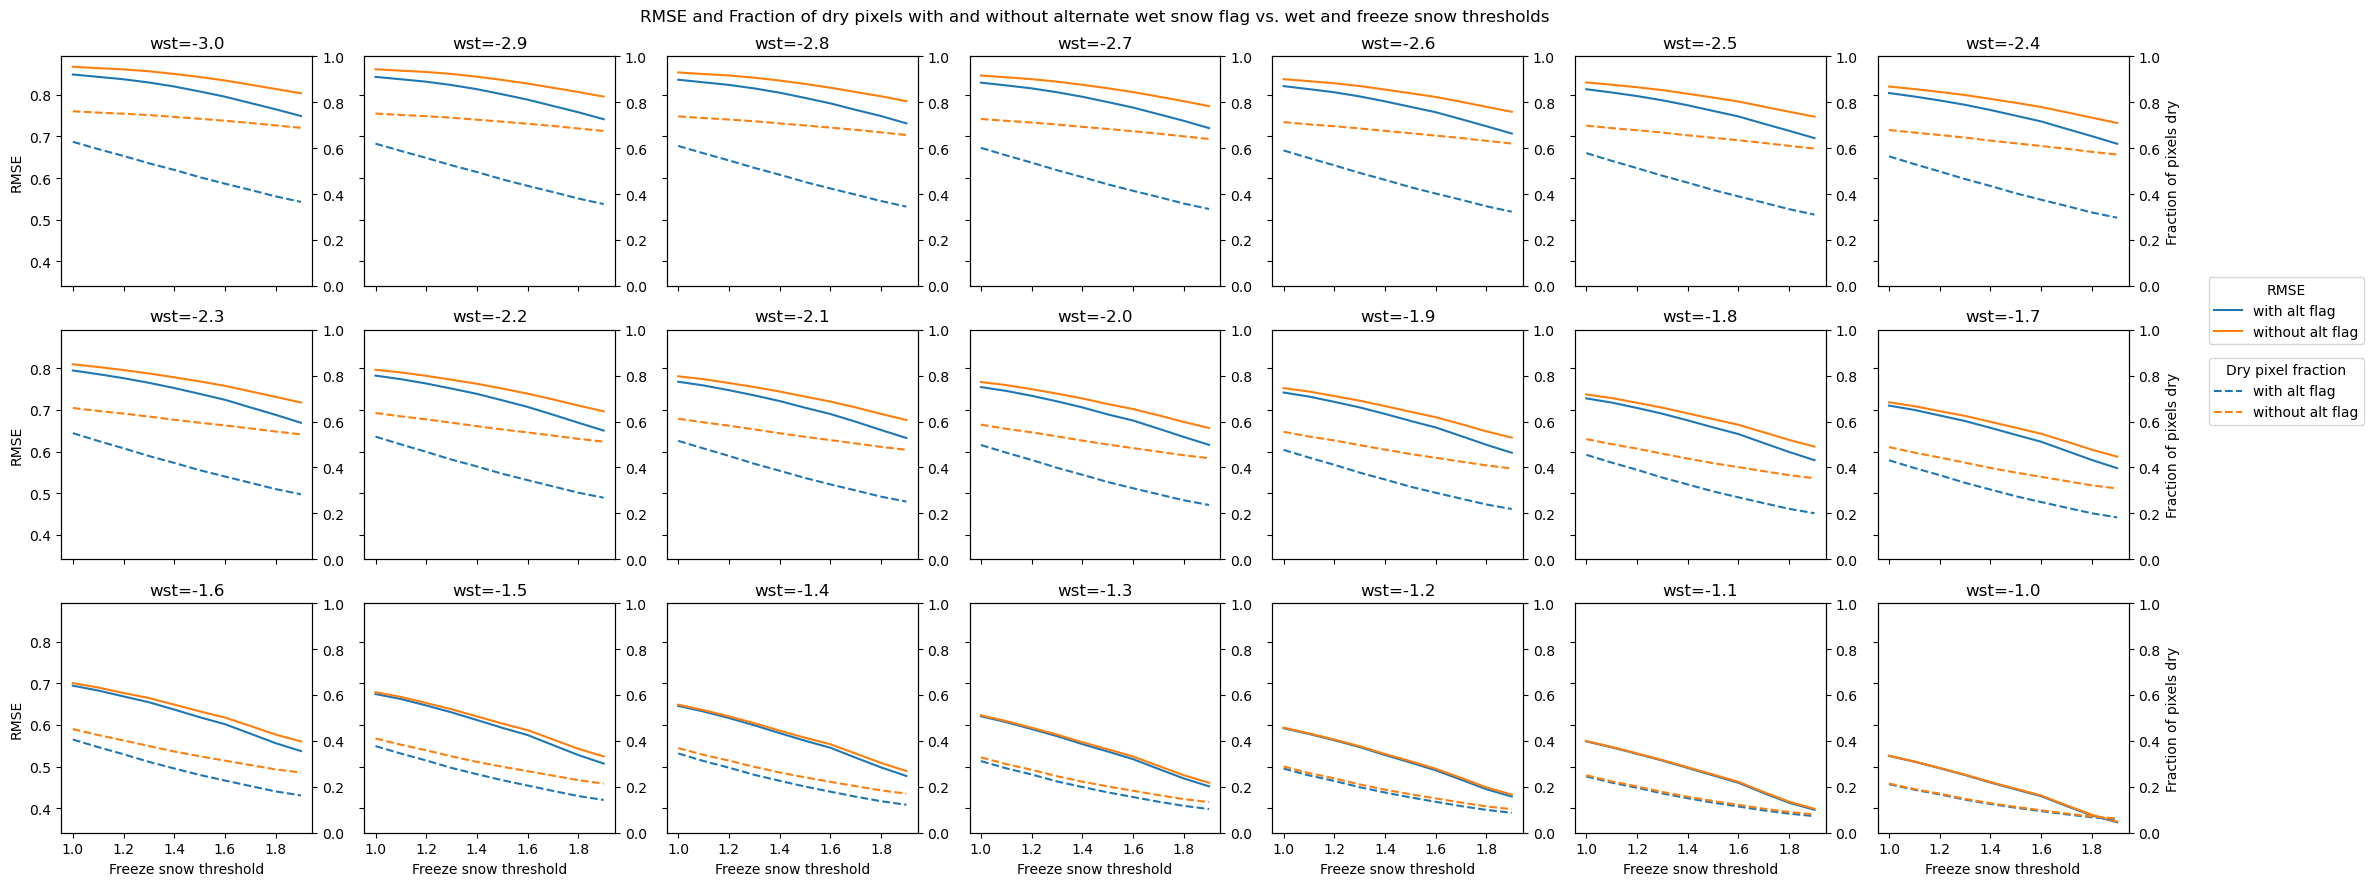

In [134]:
#sit = 0
col_wrap = 7
counter = 0
f=wet_snow.plot(hue='SI_thresh',col='wet_snow_thresh',col_wrap=col_wrap,sharey=True,add_legend=False)

for wst,ax in zip(all_rmse.wet_snow_thresh,f.axs.ravel()):
    frac_ax = ax.twinx()
    fv = frac_valid.sel(wet_snow_thresh=wst).plot(ax=frac_ax,hue='SI_thresh',label='dry pixel fraction',linestyle='--',add_legend=False)
    frac_ax.set_ylim([0,1])
    frac_ax.set_title('')
    #ax.axvline(wet_snow.sel(SI_thresh=sit,wet_snow_thresh=wst).idxmin(),color='black',linestyle='--')
    ax.set_title('')
    dry_percent = 100*frac_valid.sel(SI_thresh=sit,wet_snow_thresh=wst,freeze_snow_thresh=float(wet_snow.sel(SI_thresh=sit,wet_snow_thresh=wst).idxmin()))
    ax.set_title(f'wst={wst:0.1f}')

    if np.mod(counter,col_wrap) == 0:
        ax.set_ylabel('RMSE') 
    if np.mod(counter,col_wrap) == col_wrap-1:
        frac_ax.set_ylabel('Fraction of pixels dry') 
    if wst > -1.69:
        ax.set_xlabel('Freeze snow threshold')
    counter = counter + 1



    
f.fig.legend(labels=['with alt flag','without alt flag'], title= 'RMSE', loc='lower right',bbox_to_anchor=(1.08, 0.6))
f.fig.legend(handles=fv,labels=['with alt flag','without alt flag'], title='Dry pixel fraction', loc='upper right',bbox_to_anchor=(1.08, 0.6))

f.fig.suptitle('RMSE and Fraction of dry pixels with and without alternate wet snow flag vs. wet and freeze snow thresholds')

plt.tight_layout()

f.fig.savefig('figures/RMSE_fracdry_subplots.png',dpi=600)